In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer,FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

le=LabelEncoder()
v = DictVectorizer(sparse=True)
fh=FeatureHasher(n_features=10)
mds=MDS()
ss=StandardScaler()

%matplotlib inline

# Modelling Lyric Features
We now consider a second prediction model. Instead of embedding the raw or tokenized lyrics, we will embed features of these lyrics such as length, complexity, language and amount of profanity. Assuming all variables are categorical, we can run algorithms such as decision trees to predict genres. If there are categorical variables, we can encode them using numerical mappings or string hashing.

Import dataset

In [2]:
song_df=pd.read_csv("../Data/songdata_v2.csv",sep=',',encoding='utf-8', usecols=['lyrics','genre','song_length','complexity','language'])
print(len(song_df))
song_df.head()

56148


,language,lyrics,genre,song_length,complexity
0,NaN,"Look at her face, it's a wonderful face \r\r\...",Pop,153,0.431929
1,NaN,"Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,260,0.317946
2,NaN,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,312,0.376512
3,NaN,Making somebody happy is a question of give an...,Pop,200,0.360498
4,NaN,Making somebody happy is a question of give an...,Pop,198,0.363993


## Derived Variables
We will use the following features:
* Song length
* Complexity factor
* Profanity factor
* References to the 1st, 2nd and 3rd person (I; you; she; he)

Most of these features are ones that are not captured by the word2vec model.

In [3]:
with open('../Data/profanity.txt', 'r') as f:
    profanity = [x for x in f.read().split('\n') if x]

count_vectorizer = CountVectorizer(vocabulary=profanity)
count = count_vectorizer.fit_transform(song_df.lyrics.tolist())
count = pd.DataFrame(count.toarray(), columns=count_vectorizer.get_feature_names())
song_df['profanity']=count.sum(axis=1).div(song_df.song_length)

Note that most pronouns are stop-words and therefore not captured by text-embedding models such as word2vec.

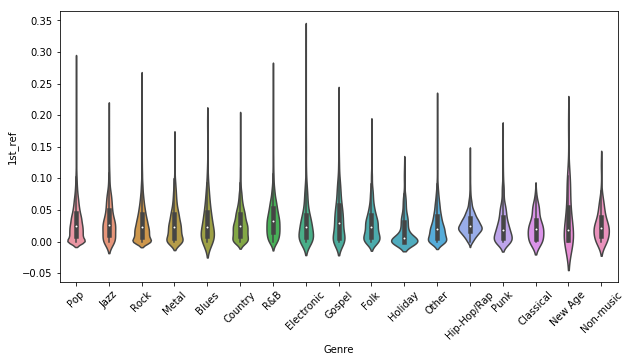

In [4]:
vocab=['i','me','my', 'myself']

count_vectorizer = CountVectorizer(vocabulary=vocab)
count = count_vectorizer.fit_transform(song_df.lyrics.tolist())
count = pd.DataFrame(count.toarray(), columns=count_vectorizer.get_feature_names())
song_df['1st_ref']=count.sum(axis=1).div(song_df.song_length)

plt.subplots(figsize=(10,5))
sns.violinplot('genre','1st_ref', data=song_df)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.show()

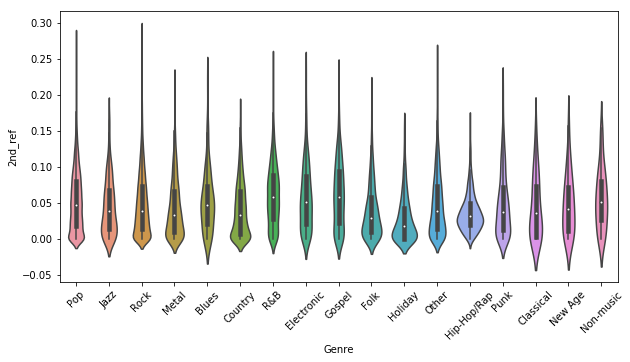

In [5]:
vocab=['you','your', 'yourself']

count_vectorizer = CountVectorizer(vocabulary=vocab)
count = count_vectorizer.fit_transform(song_df.lyrics.tolist())
count = pd.DataFrame(count.toarray(), columns=count_vectorizer.get_feature_names())
song_df['2nd_ref']=count.sum(axis=1).div(song_df.song_length)

plt.subplots(figsize=(10,5))
sns.violinplot('genre','2nd_ref', data=song_df)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.show()

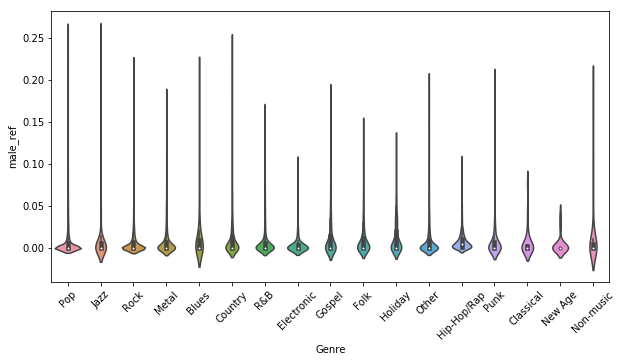

In [6]:
vocab=['he','him','his', 'man', 'boy']

count_vectorizer = CountVectorizer(vocabulary=vocab)
count = count_vectorizer.fit_transform(song_df.lyrics.tolist())
count = pd.DataFrame(count.toarray(), columns=count_vectorizer.get_feature_names())
song_df['male_ref']=count.sum(axis=1).div(song_df.song_length)

plt.subplots(figsize=(10,5))
sns.violinplot('genre','male_ref', data=song_df)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.show()

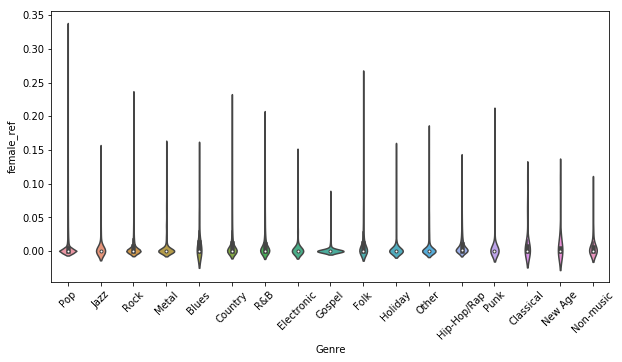

In [7]:
vocab=['she','her', 'girl', 'lady', 'woman']

count_vectorizer = CountVectorizer(vocabulary=vocab)
count = count_vectorizer.fit_transform(song_df.lyrics.tolist())
count = pd.DataFrame(count.toarray(), columns=count_vectorizer.get_feature_names())
song_df['female_ref']=count.sum(axis=1).div(song_df.song_length)

plt.subplots(figsize=(10,5))
sns.violinplot('genre','female_ref', data=song_df)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.show()

We encode categorical labels with LabelEncoder

In [8]:
song_df.drop(['lyrics'], axis=1, inplace=True)
song_df.fillna('?', inplace=True)

song_df['language']=le.fit_transform(song_df['language'])
song_df.head()

,language,genre,song_length,complexity,profanity,1st_ref,2nd_ref,male_ref,female_ref
0,0,Pop,153,0.431929,0.0,0.078431,0.000000,0.000000,0.130719
1,0,?,260,0.317946,0.0,0.123077,0.096154,0.000000,0.000000
2,0,?,312,0.376512,0.0,0.035256,0.028846,0.003205,0.000000
3,0,Pop,200,0.360498,0.0,0.005000,0.080000,0.000000,0.000000
4,0,Pop,198,0.363993,0.0,0.005051,0.080808,0.000000,0.000000


## Decision Tree Classifier

We will take a sample of 1000 observations from each genre.

In [9]:
sample_df=pd.DataFrame()
for genre in set(song_df.genre)-{'?'}:
    try:
        sample_df=sample_df.append(song_df.query("genre=='{}'".format(genre)).sample(1000))
    except:
        sample_df=sample_df.append(song_df.query("genre=='{}'".format(genre)))
print(Counter(sample_df.genre))

Counter({'R&B': 1000, 'Hip-Hop/Rap': 1000, 'Pop': 1000, 'Metal': 1000, 'Rock': 1000, 'Country': 1000, 'Other': 1000, 'Folk': 696, 'Gospel': 455, 'Punk': 437, 'Jazz': 393, 'Electronic': 364, 'Holiday': 361, 'Blues': 102, 'Non-music': 52, 'Classical': 35, 'New Age': 30})


This sample is then split into a training and testing set.

In [10]:
train,test=train_test_split(sample_df)
print('Train',Counter(train.genre))
print('Test',Counter(test.genre))

X_train = train.drop('genre', axis=1)
y_train = train['genre']

X_test = test.drop('genre', axis=1)
y_test = test['genre']

Train Counter({'Other': 765, 'Pop': 765, 'Hip-Hop/Rap': 759, 'Rock': 749, 'R&B': 745, 'Metal': 737, 'Country': 730, 'Folk': 516, 'Punk': 339, 'Gospel': 330, 'Jazz': 289, 'Electronic': 281, 'Holiday': 275, 'Blues': 73, 'Non-music': 36, 'Classical': 28, 'New Age': 26})
Test Counter({'Country': 270, 'Metal': 263, 'R&B': 255, 'Rock': 251, 'Hip-Hop/Rap': 241, 'Other': 235, 'Pop': 235, 'Folk': 180, 'Gospel': 125, 'Jazz': 104, 'Punk': 98, 'Holiday': 86, 'Electronic': 83, 'Blues': 29, 'Non-music': 16, 'Classical': 7, 'New Age': 4})


We now run the decision tree classifier:

In [11]:
dtc=DecisionTreeClassifier(random_state=0)
predicted=dtc.fit(X_train,y_train).predict(X_test) 
dict(zip(X_train.columns,list(dtc.feature_importances_)))

{'1st_ref': 0.17039632350353925,
 '2nd_ref': 0.18298014455195036,
 'complexity': 0.21691680136343683,
 'female_ref': 0.0524862636988239,
 'language': 0.027032058039356849,
 'male_ref': 0.080235047084194433,
 'profanity': 0.039577968970968665,
 'song_length': 0.23037539278772964}

## Results
We will evaluate this model in the following ways:
* Accuracy Score (% correctly classified)
* Confusion Matrix: look for model bias

In [12]:
accuracy_score(y_test,predicted)

0.20386784850926673

In [13]:
conf_mat=confusion_matrix(y_test,predicted,labels=list(set(y_test)))
conf_mat=pd.DataFrame(conf_mat, columns=list(set(y_test)))
conf_mat['index']=list(set(y_test))
conf_mat.set_index('index', inplace=True)
conf_mat

,Metal,Punk,Gospel,Rock,Country,Electronic,Other,Non-music,R&B,Folk,Hip-Hop/Rap,Blues,Holiday,Jazz,Pop,New Age,Classical
index,,,,,,,,,,,,,,,,,
Metal,35,14,22,20,16,12,48,0,23,13,9,2,15,11,17,1,5
Punk,10,9,1,6,8,5,16,0,11,9,3,1,7,6,5,0,1
Gospel,20,3,11,17,14,7,12,0,9,12,1,0,2,8,8,0,1
Rock,21,8,8,40,28,3,25,2,36,14,11,3,2,9,39,1,1
Country,24,13,3,32,51,6,18,1,33,20,10,2,4,8,44,0,1
Electronic,18,4,3,7,5,5,12,0,7,5,2,1,3,5,4,0,2
Other,24,10,20,14,22,7,38,0,25,30,5,2,11,10,15,1,1
Non-music,0,0,0,1,3,0,0,1,4,0,2,0,0,0,5,0,0
R&B,17,6,11,33,22,9,25,2,50,12,22,4,4,6,31,0,1


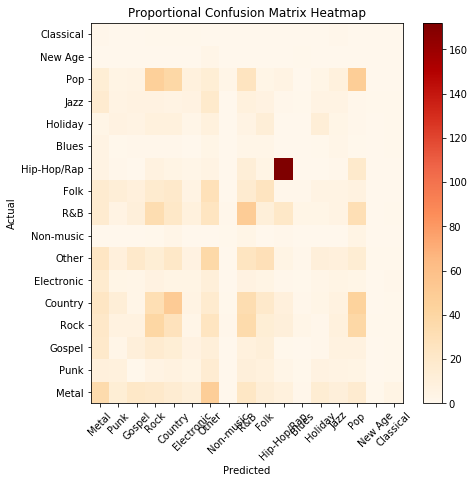

In [14]:
plt.figure(figsize=(7,7))
plt.pcolor(conf_mat, cmap='OrRd')
labels=list(set(y_test))
plt.yticks(np.arange(0.5, len(labels), 1), labels)
plt.xticks(np.arange(0.5, len(labels), 1), labels, rotation=45)
plt.title('Proportional Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.savefig('../Figures/conf_heatmap_dtc.pdf')
plt.show()

In [15]:
cross_val_score(dtc,X_train,y_train) #3-fold cross validation

array([ 0.20756235,  0.18581217,  0.18578352])

The results were not very good either. However, it does not exhibit the bias that the word2vec prediction model suffered from. It also shows that rap is a very distinct genre when considering the lyrics. After comparing all the models tested, we conclude that the music contributes most to the genre of a song, while the lyrics only make up about 20-30%.